# Лабораторные работы

## DES

DES - блочный алгоритм для симметричного шифрования.
    - Работает на блоках данных по 64 бита
    - Размер ключа - 64 бита (56 бит + 8 проверочных (parity bits))
    - Использует 16 раундов шифрования сетью фейстеля, для каждого раунда генерируется свой подключ
    - Если нужно зашифровать данные, размерном больше 64-х бит, используются слудующие (mode of operation):
        - ECB (electronic code book) - шифрование 64-битных по-порядку, не зависимо друг от друга
        - CBC (cipher block chaining) - каждый 64-битный блок открытого текста (кроме первого) складывается по модулю 2 с предыдущим результатом шифрования
        - CFB (cipher feed back) / OFB (output feed back) - схожы с CBC, но используют другие похожие схемы с xor
    - Если блок данных меньше 64-бит, используется паддинг, например, PKCS5 или, в обобщенном виде, PKCS7

#### Алгоритм

In [1]:
import bitarray
import itertools
from collections import deque


class DES(object):

    _initial_permutation = [
        58, 50, 42, 34, 26, 18, 10, 2,
        60, 52, 44, 36, 28, 20, 12, 4,
        62, 54, 46, 38, 30, 22, 14, 6,
        64, 56, 48, 40, 32, 24, 16, 8,
        57, 49, 41, 33, 25, 17, 9, 1,
        59, 51, 43, 35, 27, 19, 11, 3,
        61, 53, 45, 37, 29, 21, 13, 5,
        63, 55, 47, 39, 31, 23, 15, 7
    ]

    _final_permutation = [
        40, 8, 48, 16, 56, 24, 64, 32,
        39, 7, 47, 15, 55, 23, 63, 31,
        38, 6, 46, 14, 54, 22, 62, 30,
        37, 5, 45, 13, 53, 21, 61, 29,
        36, 4, 44, 12, 52, 20, 60, 28,
        35, 3, 43, 11, 51, 19, 59, 27,
        34, 2, 42, 10, 50, 18, 58, 26,
        33, 1, 41, 9, 49, 17, 57, 25
    ]

    _expansion_function = [
        32, 1, 2, 3, 4, 5,
        4, 5, 6, 7, 8, 9,
        8, 9, 10, 11, 12, 13,
        12, 13, 14, 15, 16, 17,
        16, 17, 18, 19, 20, 21,
        20, 21, 22, 23, 24, 25,
        24, 25, 26, 27, 28, 29,
        28, 29, 30, 31, 32, 1
    ]

    _permutation = [
        16, 7, 20, 21, 29, 12, 28, 17,
        1, 15, 23, 26, 5, 18, 31, 10,
        2, 8, 24, 14, 32, 27, 3, 9,
        19, 13, 30, 6, 22, 11, 4, 25
    ]

    _pc1 = [
        57, 49, 41, 33, 25, 17, 9,
        1, 58, 50, 42, 34, 26, 18,
        10, 2, 59, 51, 43, 35, 27,
        19, 11, 3, 60, 52, 44, 36,
        63, 55, 47, 39, 31, 23, 15,
        7, 62, 54, 46, 38, 30, 22,
        14, 6, 61, 53, 45, 37, 29,
        21, 13, 5, 28, 20, 12, 4
    ]

    _pc2 = [
        14, 17, 11, 24, 1, 5,
        3, 28, 15, 6, 21, 10,
        23, 19, 12, 4, 26, 8,
        16, 7, 27, 20, 13, 2,
        41, 52, 31, 37, 47, 55,
        30, 40, 51, 45, 33, 48,
        44, 49, 39, 56, 34, 53,
        46, 42, 50, 36, 29, 32
    ]

    _left_rotations = [
        1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1
    ]

    _sbox = [
        # S1
        [
            [14, 4, 13, 1, 2, 15, 11, 8, 3, 10, 6, 12, 5, 9, 0, 7],
            [0, 15, 7, 4, 14, 2, 13, 1, 10, 6, 12, 11, 9, 5, 3, 8],
            [4, 1, 14, 8, 13, 6, 2, 11, 15, 12, 9, 7, 3, 10, 5, 0],
            [15, 12, 8, 2, 4, 9, 1, 7, 5, 11, 3, 14, 10, 0, 6, 13]
        ],

        # S2
        [
            [15, 1, 8, 14, 6, 11, 3, 4, 9, 7, 2, 13, 12, 0, 5, 10],
            [3, 13, 4, 7, 15, 2, 8, 14, 12, 0, 1, 10, 6, 9, 11, 5],
            [0, 14, 7, 11, 10, 4, 13, 1, 5, 8, 12, 6, 9, 3, 2, 15],
            [13, 8, 10, 1, 3, 15, 4, 2, 11, 6, 7, 12, 0, 5, 14, 9]
        ],

        # S3
        [
            [10, 0, 9, 14, 6, 3, 15, 5, 1, 13, 12, 7, 11, 4, 2, 8],
            [13, 7, 0, 9, 3, 4, 6, 10, 2, 8, 5, 14, 12, 11, 15, 1],
            [13, 6, 4, 9, 8, 15, 3, 0, 11, 1, 2, 12, 5, 10, 14, 7],
            [1, 10, 13, 0, 6, 9, 8, 7, 4, 15, 14, 3, 11, 5, 2, 12]
        ],

        # S4
        [
            [7, 13, 14, 3, 0, 6, 9, 10, 1, 2, 8, 5, 11, 12, 4, 15],
            [13, 8, 11, 5, 6, 15, 0, 3, 4, 7, 2, 12, 1, 10, 14, 9],
            [10, 6, 9, 0, 12, 11, 7, 13, 15, 1, 3, 14, 5, 2, 8, 4],
            [3, 15, 0, 6, 10, 1, 13, 8, 9, 4, 5, 11, 12, 7, 2, 14]
        ],

        # S5
        [
            [2, 12, 4, 1, 7, 10, 11, 6, 8, 5, 3, 15, 13, 0, 14, 9],
            [14, 11, 2, 12, 4, 7, 13, 1, 5, 0, 15, 10, 3, 9, 8, 6],
            [4, 2, 1, 11, 10, 13, 7, 8, 15, 9, 12, 5, 6, 3, 0, 14],
            [11, 8, 12, 7, 1, 14, 2, 13, 6, 15, 0, 9, 10, 4, 5, 3]
        ],

        # S6
        [
            [12, 1, 10, 15, 9, 2, 6, 8, 0, 13, 3, 4, 14, 7, 5, 11],
            [10, 15, 4, 2, 7, 12, 9, 5, 6, 1, 13, 14, 0, 11, 3, 8],
            [9, 14, 15, 5, 2, 8, 12, 3, 7, 0, 4, 10, 1, 13, 11, 6],
            [4, 3, 2, 12, 9, 5, 15, 10, 11, 14, 1, 7, 6, 0, 8, 13]
        ],

        # S7
        [
            [4, 11, 2, 14, 15, 0, 8, 13, 3, 12, 9, 7, 5, 10, 6, 1],
            [13, 0, 11, 7, 4, 9, 1, 10, 14, 3, 5, 12, 2, 15, 8, 6],
            [1, 4, 11, 13, 12, 3, 7, 14, 10, 15, 6, 8, 0, 5, 9, 2],
            [6, 11, 13, 8, 1, 4, 10, 7, 9, 5, 0, 15, 14, 2, 3, 12]
        ],

        # S8
        [
            [13, 2, 8, 4, 6, 15, 11, 1, 10, 9, 3, 14, 5, 0, 12, 7],
            [1, 15, 13, 8, 10, 3, 7, 4, 12, 5, 6, 11, 0, 14, 9, 2],
            [7, 11, 4, 1, 9, 12, 14, 2, 0, 6, 10, 13, 15, 3, 5, 8],
            [2, 1, 14, 7, 4, 10, 8, 13, 15, 12, 9, 0, 3, 5, 6, 11]
        ]
    ]

    def __init__(self, key):
        self.key = key

    def encrypt(self, message):
        padded = self.pkcs7_padding(message, pad=True)
        result = []

        for block in padded:
            result += self.encrypt_64bit(''.join(str(i) for i in block))

        return result

    def decrypt(self, message, msg_in_bits=False):
        bits_array_msg = []
        if msg_in_bits:
            bits_array_msg = message
        else:
            bits_array_msg = self._string_to_bitsarray(message)

        if len(bits_array_msg) % 64 != 0:
            raise ValueError('Ciphered code must be a multiple of 64')

        blocks_lst = [
            bits_array_msg[i:i + 64] for i in range(0, len(bits_array_msg), 64)
        ]

        result = []

        for block in blocks_lst:
            decrypted = self.decrypt_64bit(block, msg_in_bits=True)
            bl = list(
                ''.join(chr(int(
                    ''.join(
                        map(str, decrypted[i:i + 8])),
                    2)) for i in range(0, len(decrypted), 8)))
            bl = self._unpad(bl)
            result += bl

        return ''.join(result)

    def encrypt_64bit(self, message):
        return self.crypt(message, encrypt=True)

    def decrypt_64bit(self, message, msg_in_bits=False):
        return self.crypt(message, encrypt=False, msg_in_bits=msg_in_bits)

    def crypt(self, message, encrypt=True, msg_in_bits=False):
        bits_array_msg = []
        if msg_in_bits:
            bits_array_msg = message
        else:
            bits_array_msg = self._string_to_bitsarray(message)

        bits_array_key = self._string_to_bitsarray(self.key)

        if len(bits_array_msg) != 64:
            raise ValueError('Message must be 64 bit!')

        if len(bits_array_key) != 64:
            raise ValueError('Key must be 64 bit!')

        # Compute 16 48-bit subkeys
        subkeys = self.get_subkeys(bits_array_key)

        # Convert the message using the initial permutation block
        msg = [bits_array_msg[i - 1] for i in self._initial_permutation]

        L, R = msg[:32], msg[32:]

        if encrypt:
            for i in range(16):
                prev_r = R
                r_feistel = self.feistel_function(R, subkeys[i])
                R = [L[i] ^ r_feistel[i] for i in range(32)]
                L = prev_r
        else:
            for i in reversed(range(16)):
                prev_l = L
                l_feistel = self.feistel_function(L, subkeys[i])
                L = [R[i] ^ l_feistel[i] for i in range(32)]
                R = prev_l

        before_final_permute = L + R
        return [before_final_permute[i - 1] for i in self._final_permutation]

    def pkcs7_padding(self, message, block_size=8, pad=True):
        msg = list(message)
        blocks_lst = [
            msg[i:i + block_size] for i in range(0, len(msg), block_size)
        ]

        s = block_size
        return [
            self._pad(b, s) if len(b) < block_size else b for b in blocks_lst
        ] if pad else blocks_lst

    def feistel_function(self, r_32bit, subkey_48bit):
        r_48bit = [r_32bit[i - 1] for i in self._expansion_function]
        subkey_xor_r = [r_48bit[i] ^ subkey_48bit[i] for i in range(48)]

        # Divide subkey_xor_r into 8 6-bit blocks for computing s-boxes
        b_6_bit_blocks = [subkey_xor_r[i:i + 6] for i in range(0, 48, 6)]

        # Compute 8 s-boxes and concatenate them into 32-bit vector
        after_sboxes_32bit = list(itertools.chain(*[
            self.compute_s_box(
                self._sbox[i], b_6_bit_blocks[i]) for i in range(8)
        ]))
        # Compute the permutation and return the 32-bit block
        return [int(after_sboxes_32bit[i - 1]) for i in self._permutation]

    def compute_s_box(self, sbox, b_6_bit):
        row = int(''.join(str(x) for x in [b_6_bit[0], b_6_bit[5]]), 2)
        col = int(''.join(str(x) for x in b_6_bit[1:5]), 2)
        s_box_res = sbox[row][col]
        return list('{0:04b}'.format(s_box_res))

    def get_subkeys(self, bits_array_key):
        # Extract 8 parity bits from the key (8, 16, 24, 32, 40, 48, 56, 64)
        # key_56bit = bits_array_key
        # del key_56bit[7::8]

        # Compute Permuted Choice 1 on the key
        key_56bit = [bits_array_key[i - 1] for i in self._pc1]

        # Split the key into two 28-bit subkeys
        key_56_left, key_56_right = [
            key_56bit[i:i + 28] for i in range(0, 56, 28)
        ]

        # Compute 16 48-bit keys using left rotations and permuted choice 2
        subkeys_48bit = []
        C, D = key_56_left, key_56_right
        for i in range(16):
            C_deque, D_deque = deque(C), deque(D)
            C_deque.rotate(-self._left_rotations[i])
            D_deque.rotate(-self._left_rotations[i])

            C, D = list(C_deque), list(D_deque)
            CD = C + D
            subkeys_48bit.append([CD[i - 1] for i in self._pc2])

        return subkeys_48bit

    def _string_to_bitsarray(self, string):
        ba = bitarray.bitarray()
        ba.fromstring(string)
        return [1 if i else 0 for i in ba.tolist()]

    def _pad(self, arr, block_size):
        z = block_size - len(arr)
        return arr + [z] * z

    def _unpad(self, arr):
        if str(arr[-1]).isdigit():
            arr_str = ''.join(str(i) for i in arr)
            i = j = int(arr[-1])

            while arr_str[-1] == str(j) and i > 0:
                arr_str = arr_str[:-1]
                i -= 1

            return list(arr_str)
        else:
            return arr


#### Работа алгоритма

In [2]:
d = DES('qwertyui')

cipher = d.encrypt('hello world!')

print("Ciphered bits:\n", cipher)

deciphered = d.decrypt(cipher, msg_in_bits=True)

print("Deciphered text:\n", deciphered)

Ciphered bits:
 [1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Deciphered text:
 hello world!


## Хеш-функция

    - 8-ми байтная
    - Переменные a, b, c и d после генерации складываются в шестнадцатеричном виде в порядке d, c, a, b.

#### Код функции

In [3]:
def hash_function(s=b''):
    a, b, c, d = 0xa0, 0xb1, 0x11, 0x4d

    for byte in bytearray(s):
        a ^= byte
        b = b ^ a ^ 0x55
        c = b ^ 0x94
        d = c ^ byte ^ 0x74

    return format(d << 24 | c << 16 | a << 8 | b, '08x')

#### Коллизия

Поиск 4-х байтных коллизий для хеш-функции:

In [4]:
from random import choice, seed


ascii = ''.join([chr(i) for i in range(33, 127)])

seed(37)
found = {}

for j in range(5000):
    # Build a 4 byte random string
    s = bytes(''.join([choice(ascii) for _ in range(4)]), 'ascii')
    h = hash_function(s)
    if h in found:
        v = found[h]
        if v == s:
            # Same hash, but from the same source string
            continue
        print(h, found[h], s)
    found[h] = s

6746ddd2 b'S6MU' b'I6WU'
6738f3ac b'46z+' b'k6%+'
6d7cb7e8 b't<:e' b'h<&e'
2038d3ac b'&qHl' b'8qVl'
1639daad b'2GT[' b'XG>['
6d2ff1bb b"|<'6" b'9<b6'
0f50d1c4 b'1^5+' b'Q^U+'
7e45cbd1 b'r/yO' b'}/vO'
0326a4b2 b'GR@Q' b'&R!Q'
3c1ab88e b'jmMR' b'}mZR'
0405e591 b'_U:u' b',UIu'
692ccfb8 b'E8#1' b']8;1'
0a11f485 b'V[6o' b'6[Vo'
634486d0 b'!2fS' b'.2iS'
7e46c6d2 b'2/7L' b'4/1L'


#### Кривая вероятности коллизии на выбранном интервале

Расчет вероятностей коллизии для хеш-выборок заданного размера с использованием принципа парадокса дней рождения.

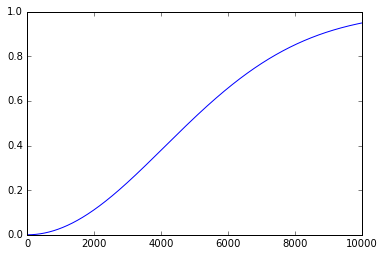

In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

# Calculate the probability of collision among 10000 keys using Birthday Paradox Principle
n = num_of_all_hashes = 8 ** 8  # 16777216
keys = 10000
probUnique = 1.0
keys_arr = np.array(range(1, keys))
coll_probs = []

for k in range(1, keys):
    probUnique = probUnique * (n - (k - 1)) / n
    coll_probs.append((1 - math.exp(-0.5 * k * (k - 1) / n)))

plt.plot(keys_arr, coll_probs)
plt.show()


## Протокол Диффи-Хеллмана

Позволяет двум или более сторонам получить общий секретный ключ, используя незащищенный от прослушивания канал связи. Полученный ключ используется для шифрования дальнейшего обмена с помощью алгоритмов симметричного шифрования.

Использует операции возведения в степень по модулю и симметричность модульной арифметики.

#### Код алгоритма

In [22]:
from hashes.hash_function import hash_function
from binascii import hexlify
try:
    import ssl
    random_function = ssl.RAND_bytes
    random_provider = "Python SSL"
except (AttributeError, ImportError):
    import OpenSSL
    random_function = OpenSSL.rand.bytes
    random_provider = "OpenSSL"


class DiffieHellman(object):

    def __init__(self, generator=2, prime=11,
                 key_length=540, private_key=None):
        self.generator = generator
        self.key_length = key_length
        self.prime = prime

        if private_key:
            self.private_key = private_key
        else:
            self.private_key = self.gen_private_key(self.key_length)

        self.public_key = self.gen_public_key()

    def get_random(self, bits):
        _rand = 0
        _bytes = bits

        while _rand.bit_length() < bits:
            _rand = int.from_bytes(random_function(_bytes), byteorder='big')

        return _rand

    def gen_private_key(self, bits):
        return self.get_random(bits)

    def gen_public_key(self):
        return pow(self.generator, self.private_key, self.prime)

    def gen_secret(self, private_key, other_key):
        return pow(other_key, private_key, self.prime)

    def gen_key(self, other_key):
        self.shared_secret = self.gen_secret(self.private_key, other_key)

        try:
            _shared_secret_bytes = self.shared_secret.to_bytes(
                self.shared_secret.bit_length() // 8 + 1, byteorder='big'
            )
        except AttributeError:
            _shared_secret_bytes = str(self.shared_secret)

        # self.key = hash_function(bytes(_shared_secret_bytes, 'ascii'))
        self.key = hash_function(_shared_secret_bytes)

    def get_key(self):
        return self.key

    def get_shared_secret(self):
        return self.shared_secret

    def show_params(self):
        print('Parameters:')
        print('Prime [{0}]: {1}'.format(self.prime.bit_length(), self.prime))
        print(
            'Generator [{0}]: {1}\n'
            .format(self.generator.bit_length(), self.generator))
        print(
            'Private key [{0}]: {1}\n'
            .format(self.private_key.bit_length(), self.private_key))
        print(
            'Public key [{0}]: {1}'
            .format(self.public_key.bit_length(), self.public_key))

    def show_results(self):
        print('Results:')
        print(
            'Shared secret [{0}]: {1}'
            .format(self.shared_secret.bit_length(), self.shared_secret))
        print(
            'Shared key [{0}]: {1}'.format(len(self.key),
                                           hexlify(bytes(self.key, 'ascii'))))


#### Работа алгоритма:

In [23]:
p = 11
g = 2

d1 = DiffieHellman(generator=g, prime=p, key_length=3)
d2 = DiffieHellman(generator=g, prime=p, key_length=3)

print(d1.public_key)
print(d2.public_key)

d1.gen_key(d2.public_key)
d2.gen_key(d1.public_key)

d1.show_params()
d1.show_results()
d2.show_params()
d2.show_results()

if d1.get_key() == d2.get_key():
    print('Shared keys match')
    print('Key: ', hexlify(bytes(d1.key, 'ascii')))
    print(d1.get_key())
else:
    print("Shared secrets didn't match!")
    print("Shared secret A: ", d1.gen_secret(d2.public_key))
    print("Shared secret B: ", d2.gen_secret(d1.public_key))

6
4
Parameters:
Prime [4]: 11
Generator [2]: 2

Private key [24]: 13691899

Public key [3]: 6
Results:
Shared secret [2]: 3
Shared key [8]: b'6134643361333437'
Parameters:
Prime [4]: 11
Generator [2]: 2

Private key [24]: 10217552

Public key [3]: 4
Results:
Shared secret [2]: 3
Shared key [8]: b'6134643361333437'
Shared keys match
Key:  b'6134643361333437'
a4d3a347


## Алгоритм RSA

RSA - ассиметричный криптографический алгоритм, использующий открытые и закрытые ключи.

    - Открытый ключ - пара (e, N), где e - открытая экспонента, N - результат выполнения функции Эйлера
    - Закрытый ключ - пара (d, N), где d - число, мультипликативно обратное открытой экспоненте, N - результат выполнения функции Эйлера
    - Данные шифруются открытым ключем, а расшифровываются закрытым.
    - Функция Эйлера - выражение вида (p - 1) * (q - 1), где p и q - простые случайные числа
    - Шифрование происходит за счет операций возведения в степень по модулю с открытыми данными и ключем
    

#### Код алгоритма:

In [24]:
import json
from random import randint
from base64 import b64encode, b64decode


class RSA(object):

    def __init__(self):
        self.p, self.q = self.gen_p_q()
        self.N = self.p * self.q
        self.phi = self.euler_function(self.p, self.q)
        self.public_key_pair = (self.gen_public_exponent(), self.N)
        self.private_key_pair = (self.gen_private_exponent(), self.N)

    def encrypt(self, message, public_key_pair):
        return self.crypt(message, public_key_pair, encrypt=True)

    def decrypt(self, cipher, private_key_pair):
        return self.crypt(cipher, private_key_pair, encrypt=False)

    def crypt(self, message, key_pair, encrypt=True):
        if encrypt:
            msg = [ord(c) for c in message]
            r = [pow(i, key_pair[0], key_pair[1]) for i in msg]
            return b64encode(bytes(json.dumps(r), 'utf8')).decode('utf8'), r
        else:
            msg = json.loads(b64decode(message).decode('utf8'))
            r = [pow(i, key_pair[0], key_pair[1]) for i in msg]
            return ''.join(chr(i) for i in r), r

    def get_public_key_pair(self):
        return self.public_key_pair

    def get_private_key_pair(self):
        return self.private_key_pair

    def get_phi(self):
        return self.phi

    def get_p_q(self):
        return self.p, self.q

    def gen_public_exponent(self):
        for e in reversed(range(self.phi)):
            if self.fermat_primality(e):
                self.e = e
                return e

    def gen_private_exponent(self):
        self.d = self.mod_multiplicative_inv(self.e, self.phi)[0]
        return self.d

    def euler_function(self, p, q):
        return (p - 1) * (q - 1)

    def gen_p_q(self):
        p_c, q_c = randint(2, 100000), randint(2, 100000)
        p = q = None
        gen1 = gen2 = self.eratosthenes_sieve()
        bigger = max(p_c, q_c)

        for i in range(bigger):
            if p_c > 0:
                p = next(gen1)
            if q_c > 0:
                q = next(gen2)
            p_c -= 1
            q_c -= 1

        return p, q

    def fermat_primality(self, n):
        if n == 2:
            return True
        if not n & 1:
            return False
        return pow(2, n - 1, n) == 1

    def extended_euclide(self, b, n):
        # u*a + v*b = gcd(a, b)
        # return g, u, v
        x0, x1, y0, y1 = 1, 0, 0, 1
        while n != 0:
            q, b, n = b // n, n, b % n
            x0, x1 = x1, x0 - q * x1
            y0, y1 = y1, y0 - q * y1
        return b, x0, y0

    def mod_multiplicative_inv(self, a, b):
        g, u, v = self.extended_euclide(a, b)
        return b + u, a - v

    def eratosthenes_sieve(self):
        D = {}
        q = 2

        while True:
            if q not in D:
                yield q
                D[q * q] = [q]
            else:
                for p in D[q]:
                    D.setdefault(p + q, []).append(p)
                del D[q]
            q += 1

    def print_info(self):
        print('p = %d\nq = %d' % (self.p, self.q))
        print('N = %d\nphi = %d' % (self.N, self.phi))
        print('e = %d\nd = %d' % (self.e, self.d))

#### Работа алгоритма:

In [26]:
rsa = RSA()
message = 'hello!'
cipher = rsa.encrypt(message, rsa.get_public_key_pair())
print('Cipher:\n', cipher[0])
deciphered = rsa.decrypt(cipher[0], rsa.get_private_key_pair())
print('Deciphered text:\n', deciphered[0])

rsa.print_info()

Cipher:
 WzkwOTA2NzU5NjgxMywgNDg1OTYwODkwODg4LCA3NTE4MzE5MjE4ODgsIDc1MTgzMTkyMTg4OCwgMTAzNDc3NDA1OTMyNiwgNTMyNTI5NTYwNTM0XQ==
Deciphered text:
 hello!
p = 1209469
q = 962789
N = 1164463449041
phi = 1164461276784
e = 1164461276753
d = 1202024543777


## ЭЦП

Реализация упрощенной электронной цифровой подписи.

$$H_i = (H_{i-1} + M_i)^2 \mod n,H_0 = 0$$

$$S = H ^ d \mod n$$

$$H' = S^e \mod n$$

#### Код алгоритма:

In [37]:
import re


class Signature(object):

    def __init__(self, public_key, private_key, n):
        self.public_key = public_key
        self.private_key = private_key
        self.n = n

    def sign(self, message, private_key):
        H = self.hash_function(message)
        signature = pow(H, private_key, self.n)
        return '@' + str(signature) + '@' + message

    def verify(self, message, public_key):
        regex = re.compile('@\d+@')
        match = regex.search(message)

        if match:
            signature = int(match.group(0).strip('@'))
            msg = regex.sub('', message)

            H1 = pow(signature, public_key, self.n)
            H2 = self.hash_function(msg)

            return H1 == H2

    def hash_function(self, message):
        H = 0
        for c in [ord(c) for c in message]:
            H = (H + c)**2 % self.n
        return H

    def get_public_key(self):
        return self.public_key

    def get_private_key(self):
        return self.private_key

#### Демонстрация работы ЭЦП:

In [40]:
public_key = 5
private_key = 29
n = 91

signature = Signature(public_key, private_key, n)
message = 'hello!'

signed_message = signature.sign(message, signature.get_private_key())  # sign the message
print('Initial message: ', message)
print('Signed message: ', signed_message)

if signature.verify(signed_message, public_key):
    print('Verification successful! Message was not modified.\n')
else:
    print('Verification error! Message was modified.\n')


modified_message = signed_message + ' hi!'  # modify signed message
print('Modified message: ', modified_message)

if signature.verify(modified_message, public_key):
    print('Verification successful! Message was not modified.')
else:
    print('Verification error! Message was modified')

Initial message:  hello!
Signed message:  @29@hello!
Verification successful! Message was not modified.

Modified message:  @29@hello! hi!
Verification error! Message was modified


# Практические занятия

## Шифр Цезаря

#### Шифрование:

In [23]:
def cipher(text, alphabet='abcdefghijklmnopqrstuvwxyz', key=0):
    result = ""
    alphabet = alphabet.lower()
    n = len(alphabet)
    for char in text:
        if char.isalpha():
            new_char = alphabet[(alphabet.find(char.lower()) + key) % n]
            result += new_char if char.islower() else new_char.upper()
        else:
            result += char

    return result

#### Расшифровывание:

In [22]:
def decipher(text, alphabet='abcdefghijklmnopqrstuvwxyz', key=0):
    result = ""
    alphabet = alphabet.lower()
    n = len(alphabet)
    for char in text:
        if char.isalpha():
            new_char = alphabet[(alphabet.find(char.lower()) - key + n) % n]
            result += new_char if char.islower() else new_char.upper()
        else:
            result += char

    return result

#### Демонстрация работы алгоритма:

In [24]:
alphabet = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'
text = 'Съешь же ещё этих мягких французских булок, да выпей чаю.'
key = 3

ciphered_phrase = cipher(text, alphabet, key)
print(ciphered_phrase)

deciphered_phrase = decipher(ciphered_phrase, alphabet, key)
print(deciphered_phrase)

Фэзыя йз зьи ахлш пвёнлш чугрщцкфнлш дцосн, жг еютзм ъгб.
Съешь же ещё этих мягких французских булок, да выпей чаю.


#### Криптоанализ

Взломать шифр Цезаря можно, используя частоты букв алфавита и вычисление наименьшей энтропии

##### Код для взлома шифров на английском языке:

In [20]:
import numpy as np

ENGLISH_FREQS = [
    0.08167, 0.01492, 0.02782, 0.04253, 0.12702, 0.02228,
    0.02015, 0.06094, 0.06966, 0.00153, 0.00772, 0.04025,
    0.02406, 0.06749, 0.07507, 0.01929, 0.00095, 0.05987,
    0.06327, 0.09056, 0.02758, 0.00978, 0.02360, 0.00150,
    0.01974, 0.00074
]


# Returns the cross-entropy of the given string with respect to
# the English unigram frequencies, which is a positive
# floating-point number.
def get_entropy(str):
    sum, ignored = 0, 0
    for c in str:
        if c.isalpha():
            sum += np.log(ENGLISH_FREQS[ord(c.lower()) - 97])
        else:
            ignored += 1
    return -sum / np.log(2) / (len(str) - ignored)


# Returns the entropies when the given string is decrypted with
# all 26 possible shifts, where the result is an array of tuples
# (int shift, float enptroy) -
# e.g. [(0, 2.01), (1, 4.95), ..., (25, 3.73)].
def get_all_entropies(str):
    result = []
    for i in range(0, 26):
        result.append((i, get_entropy(decipher(str, key=i))))
    return result


def cmp_to_key(mycmp):
    'Convert a cmp= function into a key= function'
    class K(object):
        def __init__(self, obj, *args):
            self.obj = obj

        def __lt__(self, other):
            return mycmp(self.obj, other.obj) < 0

        def __gt__(self, other):
            return mycmp(self.obj, other.obj) > 0

        def __eq__(self, other):
            return mycmp(self.obj, other.obj) == 0

        def __le__(self, other):
            return mycmp(self.obj, other.obj) <= 0

        def __ge__(self, other):
            return mycmp(self.obj, other.obj) >= 0

        def __ne__(self, other):
            return mycmp(self.obj, other.obj) != 0
    return K


def comparator(x, y):
    if x[1] < y[1]:
        return -1
    elif x[1] > y[1]:
        return 1
    elif x[0] < y[0]:
        return -1
    elif x[0] > y[0]:
        return 1
    else:
        return 0


##### Демонстрация работы кода:

In [25]:
text = 'hello'
ciphered = cipher(text, alphabet='abcdefghijklmnopqrstuvwxyz', key=14)

print('Initial text: ', text)
print('Ciphered text: ', ciphered)

entropies = get_all_entropies(ciphered)
entropies.sort(key=cmp_to_key(comparator))
best_shift = entropies[0][0]
cracked_val = decipher(ciphered, key=best_shift)
print('\nBest guess:')
print('%d rotations\nDeiphered text: %s\n' % (best_shift, cracked_val))

print('=========\nFull circle:')
for i in range(0, 26):
    print('%d -\t%s' % (i, decipher(ciphered, key=i)))

Initial text:  hello
Ciphered text:  vszzc

Best guess:
14 rotations
Deiphered text: hello

Full circle:
0 -	vszzc
1 -	uryyb
2 -	tqxxa
3 -	spwwz
4 -	rovvy
5 -	qnuux
6 -	pmttw
7 -	olssv
8 -	nkrru
9 -	mjqqt
10 -	lipps
11 -	khoor
12 -	jgnnq
13 -	ifmmp
14 -	hello
15 -	gdkkn
16 -	fcjjm
17 -	ebiil
18 -	dahhk
19 -	czggj
20 -	byffi
21 -	axeeh
22 -	zwddg
23 -	yvccf
24 -	xubbe
25 -	wtaad


## Шифр Виженера

Шифр Виженера — метод полиалфавитного шифрования буквенного текста с использованием ключевого слова.

#### Код алгоритма:

In [16]:
import string


class Vigenere(object):

    def __init__(self, key):
        self.key = key
        self.tabula_recta = self.generate_tabula_recta()

    def encrypt(self, msg):
        msg_l = len(msg)
        key = self.adjust_key(self.key, msg_l)
        return ''.join(self.tabula_recta[msg[i]][key[i]] for i in range(msg_l))

    def decrypt(self, msg):
        msg_l, t = len(msg), self.tabula_recta
        key = self.adjust_key(self.key, msg_l)
        return ''.join(
            list(t[key[i]].keys())[
                list(t[key[i]].values()).index(msg[i])
            ] for i in range(msg_l)
        )

    def generate_tabula_recta(self):
        alphabet = a = list(string.ascii_uppercase)
        n = len(alphabet)
        tabula_recta = dict()

        for index, row_c in enumerate(alphabet):
            tabula_recta[row_c] = dict()
            for col_c in alphabet:
                tabula_recta[row_c][col_c] = a[(a.index(col_c) + index) % n]

        return tabula_recta

    def adjust_key(self, key, length):
        key_len = len(key)
        return ''.join([key[(i + key_len) % key_len] for i in range(length)])

    def get_key(self):
        return self.key

    def get_tabula_recta(self):
        return self.tabula_recta

    def pretty_print(self, d, space=3, fill='-'):
        strs = ''.join('{{{0}:^{1}}}'.format(
            str(i), str(space)) for i in range(len(d) + 1)
        )
        std = sorted(d)
        print(strs.format(" ", *std))
        for x in std:
            print(strs.format(x, *(d[x].get(y, fill) for y in std)))


#### Tabula Recta - таблицы Виженера:

In [17]:
v = Vigenere('TEST')
v.pretty_print(v.get_tabula_recta(), space=3)

    A  B  C  D  E  F  G  H  I  J  K  L  M  N  O  P  Q  R  S  T  U  V  W  X  Y  Z 
 A  A  B  C  D  E  F  G  H  I  J  K  L  M  N  O  P  Q  R  S  T  U  V  W  X  Y  Z 
 B  B  C  D  E  F  G  H  I  J  K  L  M  N  O  P  Q  R  S  T  U  V  W  X  Y  Z  A 
 C  C  D  E  F  G  H  I  J  K  L  M  N  O  P  Q  R  S  T  U  V  W  X  Y  Z  A  B 
 D  D  E  F  G  H  I  J  K  L  M  N  O  P  Q  R  S  T  U  V  W  X  Y  Z  A  B  C 
 E  E  F  G  H  I  J  K  L  M  N  O  P  Q  R  S  T  U  V  W  X  Y  Z  A  B  C  D 
 F  F  G  H  I  J  K  L  M  N  O  P  Q  R  S  T  U  V  W  X  Y  Z  A  B  C  D  E 
 G  G  H  I  J  K  L  M  N  O  P  Q  R  S  T  U  V  W  X  Y  Z  A  B  C  D  E  F 
 H  H  I  J  K  L  M  N  O  P  Q  R  S  T  U  V  W  X  Y  Z  A  B  C  D  E  F  G 
 I  I  J  K  L  M  N  O  P  Q  R  S  T  U  V  W  X  Y  Z  A  B  C  D  E  F  G  H 
 J  J  K  L  M  N  O  P  Q  R  S  T  U  V  W  X  Y  Z  A  B  C  D  E  F  G  H  I 
 K  K  L  M  N  O  P  Q  R  S  T  U  V  W  X  Y  Z  A  B  C  D  E  F  G  H  I  J 
 L  L  M  N  O  

#### Демонстрация работы алгоритма:

In [18]:
key = 'LEMON'
message = 'ATTACKATDAWN'

vigenere = Vigenere(key)
cipher = vigenere.encrypt(message)
deciphered = vigenere.decrypt(cipher)

print('Key:\t\t', key)
print('Message:\t', message)
print('Ciphered:\t', cipher)
print('Deciphered:\t', deciphered)

Key:		 LEMON
Message:	 ATTACKATDAWN
Ciphered:	 LXFOPVEFRNHR
Deciphered:	 ATTACKATDAWN
